![Cover Page](cover_page.png)


# Introduction

Low back pain is the leading cause of disability worldwide, as reported by the World Health Organization, affecting approximately 619 million people in 2020. The prevalence of low back pain increases with age, with most individuals experiencing it at some point in their lives. Pain and limited mobility are common symptoms of spondylosis, a collection of degenerative spine conditions characterized by the degeneration of intervertebral discs and subsequent narrowing of the spinal canal (spinal stenosis). This can lead to compression or irritation of the nerves in the lower back, significantly impacting the quality of life.

Magnetic Resonance Imaging (MRI) offers a detailed visualization of the lumbar spine, including vertebrae, discs, and nerves, enabling radiologists to assess the presence and severity of degenerative conditions accurately. Proper diagnosis and grading of these conditions are crucial for guiding treatment and potential surgical interventions aimed at alleviating back pain and enhancing overall health.

The Radiological Society of North America (RSNA) has partnered with the American Society of Neuroradiology (ASNR) to conduct a competition exploring the potential of artificial intelligence (AI) in aiding the detection and classification of degenerative spine conditions using lumbar spine MRI images.

## Problem Statement

The challenge focuses on the classification of five lumbar spine degenerative conditions:

1. **Left Neural Foraminal Narrowing**
2. **Right Neural Foraminal Narrowing**
3. **Left Subarticular Stenosis**
4. **Right Subarticular Stenosis**
5. **Spinal Canal Stenosis**

For each imaging study in the dataset, severity scores (Normal/Mild, Moderate, or Severe) have been provided for these five conditions across the intervertebral disc levels L1/L2, L2/L3, L3/L4, L4/L5, and L5/S1.

The ground truth dataset was created through collaboration between the RSNA challenge planning task force and eight imaging sites across five continents. This expertly curated, multi-institutional dataset aims to enhance standardized classification of degenerative lumbar spine conditions and facilitate the development of tools for accurate and rapid disease classification.

## Evaluation Metrics

Submissions for the competition will be evaluated based on the average of sample weighted log losses and an `any_severe_spinal` prediction. The specific sample weights are as follows:

- **1** for Normal/Mild
- **2** for Moderate
- **4** for Severe

For each row ID in the test set, predictions must include probabilities for each severity level. The submission file should contain a header and adh
In some instances, the lowest vertebrae may not be visible in the imagery. It is still necessary to make predictions for these cases; however, they will not be scored.

For this competition, the `any_severe_scalar` is set to **1.0*.org).
ere to the following format:



In [1]:
import numpy as np
import pandas as pd 
import SimpleITK as sitk
import numpy as np
import torch
from torchvision import transforms
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<01:13, 2.09kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<01:45, 4.85kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<02:10, 3.71kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<02:42, 5.67kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<04:51, 21.0kB/s]


## Data Overview

In this section, we will provide an overview of the datasets used in the project. We will detail the characteristics of each dataset, including the number of entries, columns, and data types.

### Training Dataset (`train_df`)

The training dataset contains the features and target variables for our machine learning model. It has a total of **1975** entries and **26** columns.

### Test Description Dataset (test_description_df)
The test description dataset provides information about the test set and consists of 3 entries and 3 columns.


In [2]:
# Define the path for the dataset
train_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'

# Load CSV files
train_df = pd.read_csv(os.path.join(train_path, 'train.csv'))
label_df = pd.read_csv(os.path.join(train_path, 'train_label_coordinates.csv'))
train_description_df = pd.read_csv(os.path.join(train_path, 'train_series_descriptions.csv'))
test_description_df = pd.read_csv(os.path.join(train_path, 'test_series_descriptions.csv'))
submission_df = pd.read_csv(os.path.join(train_path, 'sample_submission.csv'))

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   study_id                                1975 non-null   int64 
 1   spinal_canal_stenosis_l1_l2             1974 non-null   object
 2   spinal_canal_stenosis_l2_l3             1974 non-null   object
 3   spinal_canal_stenosis_l3_l4             1974 non-null   object
 4   spinal_canal_stenosis_l4_l5             1974 non-null   object
 5   spinal_canal_stenosis_l5_s1             1974 non-null   object
 6   left_neural_foraminal_narrowing_l1_l2   1973 non-null   object
 7   left_neural_foraminal_narrowing_l2_l3   1973 non-null   object
 8   left_neural_foraminal_narrowing_l3_l4   1973 non-null   object
 9   left_neural_foraminal_narrowing_l4_l5   1973 non-null   object
 10  left_neural_foraminal_narrowing_l5_s1   1973 non-null   object
 11  righ

In [5]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48692 entries, 0 to 48691
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   study_id         48692 non-null  int64  
 1   series_id        48692 non-null  int64  
 2   instance_number  48692 non-null  int64  
 3   condition        48692 non-null  object 
 4   level            48692 non-null  object 
 5   x                48692 non-null  float64
 6   y                48692 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.6+ MB


In [6]:
test_description_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   study_id            3 non-null      int64 
 1   series_id           3 non-null      int64 
 2   series_description  3 non-null      object
dtypes: int64(2), object(1)
memory usage: 200.0+ bytes


## Image Path Generation

In this section, we define a function that generates image paths based on the directory structure of the dataset. The function takes in a DataFrame containing study and series IDs, along with the base directory where the images are stored. 

### Function: `generate_image_paths`

This function traverses the directory structure for each study and series ID, retrieves the filenames of the images, and constructs full paths to these images.

#### Parameters:
- `df` (pd.DataFrame): A DataFrame containing the `study_id` and `series_id`.
- `data_dir` (str): The base directory path where the images are stored.

#### Returns:
- `list`: A list of full paths to the images.

### Code Implementation


In [7]:
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        
        # List images in the series directory
        images = os.listdir(series_dir)
        # Create full paths for each image
        image_paths.extend([os.path.join(series_dir, img) for img in images])
        
    return image_paths

### Image Path Verification

The generated paths for both the training and test images are as follows:

#### Train Image Pa#### Test Image Pathsths


In [8]:
import os
import pandas as pd

# Assuming your previous functions and imports are already in place

# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_description_df, os.path.join(train_path, 'train_images'))
test_image_paths = generate_image_paths(test_description_df, os.path.join(train_path, 'test_images'))

# Print to verify paths
print("Train Image Paths:")
print(train_image_paths[:5])  # Print the first 5 train image paths

print("\nTest Image Paths:")
print(test_image_paths[:5])  # Print the first 5 test image paths


Train Image Paths:
['/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/12.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/9.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/14.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/11.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/10.dcm']

Test Image Paths:
['/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845/12.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845/18.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845/9.dcm', '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845/22.dcm', '/ka

## Image Visualization

In this section, we visualize a set of images from the training and testing datasets. We utilize the `SimpleITK` library to read DICOM images and display them using `matplotlib`. The goal is to provide a visual understanding of the data we are working with, specifically focusing on lumbar spine images that relate to degenerative conditions.

### Function: `visualize_images`

This function takes a list of image paths and the number of images to display, then renders these images in a grid format.

#### Parameters:
- `image_paths` (list): A list of full paths to the images to visualize.
- `num_images` (int): The number of images to display (default is 5).

### Code Implementation


Visualizing Original Training Images:


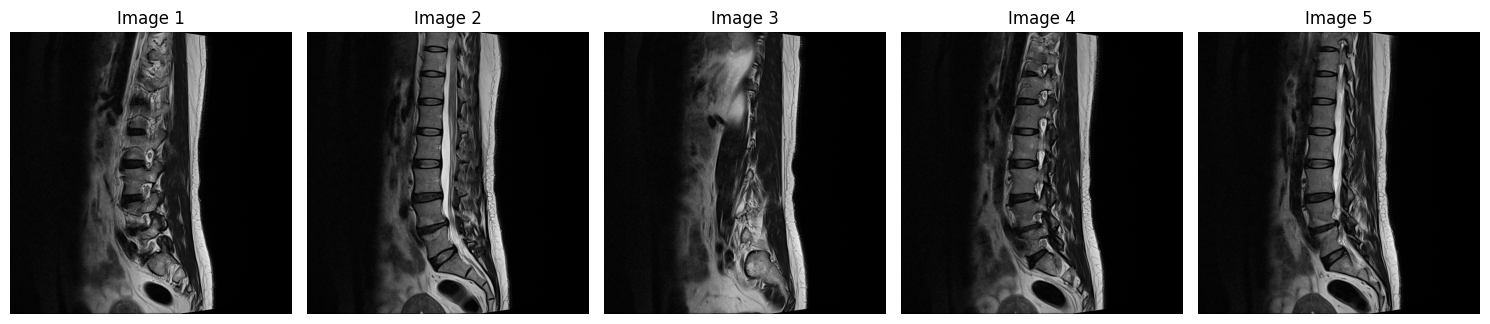

Visualizing Original Testing Images:


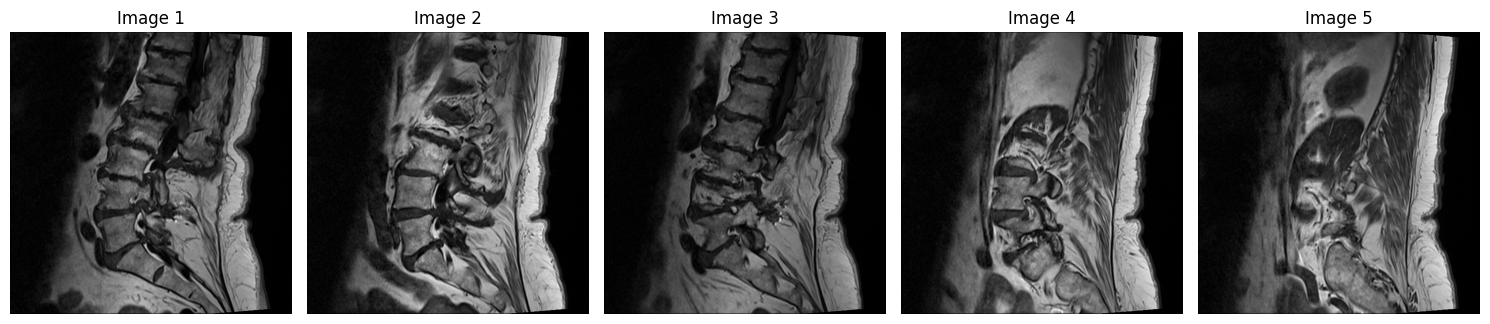

In [9]:
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image

# Function to visualize a set of images
def visualize_images(image_paths, num_images=5):
    plt.figure(figsize=(15, 10))
    
    # Loop through the number of images to display
    for i in range(num_images):
        # Load the DICOM image using SimpleITK
        image = sitk.ReadImage(image_paths[i])
        image_array = sitk.GetArrayFromImage(image)  # Convert to NumPy array
        image_array = np.squeeze(image_array)  # Remove single-dimensional entries
        
        # Convert NumPy array to PIL Image
        pil_image = Image.fromarray(image_array)

        # Plotting the original image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(pil_image, cmap='gray')  # Display as grayscale
        plt.axis('off')  # Hide axis
        plt.title(f'Image {i + 1}')
    
    plt.tight_layout()
    plt.show()

# Visualize original training images
print("Visualizing Original Training Images:")
visualize_images(train_image_paths, num_images=5)

# Visualize original testing images
print("Visualizing Original Testing Images:")
visualize_images(test_image_paths, num_images=5)


## Structuring the DataFrame

In this section, we transform the original `train_df` DataFrame into a more structured format that is easier to work with for analysis and modeling. The goal is to create a long-form DataFrame where each row corresponds to a specific condition, its level, and severity for a given study.

### Data Structure

The new structured DataFrame will have the following columns:
- **study_id**: Identifier for the study.
- **condition**: The degenerative condition being analyzed (e.g., "Left Neural Foraminal Narrowing").
- **level**: The specific intervertebral disc level being assessed (e.g., "L1/L2").
- **severity**: The severity of the condition, categorized as Normal/Mild, Moderate, or Severe.

### Code Implementation


In [10]:
# Initialize a list to hold the structured data
structured_df = []

# Iterate through each row in the train DataFrame
for _, row in train_df.iterrows():
    # Initialize a dictionary to hold data for the current row
    df = {
        'study_id': [],
        'condition': [],
        'level': [],
        'severity': []
    }
    
    # Iterate through the columns in the current row
    for column, value in row.items():
        # Skip specific columns that do not contribute to the structured data
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            # Split the column name to get condition and level
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])  # Construct condition name
            level = f"{parts[-2].capitalize()}/{parts[-1].capitalize()}"  # Construct level

            # Append the data to the dictionary
            df['study_id'].append(row['study_id'])
            df['condition'].append(condition)
            df['level'].append(level)
            df['severity'].append(value)
    
    # Append the dictionary as a DataFrame to the structured_df list
    structured_df.append(pd.DataFrame(df))

# all individual DataFrames into a single DataFrame
structured_df = pd.concat(structured_df, ignore_index=True)

# Display the structured DataFrame
structured_df.head()


,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


## Merging DataFrames

In this section, we perform two merging operations to combine the structured data with labels and descriptions. The goal is to create a comprehensive DataFrame that contains all relevant information needed for model training.

### Merge Operations

1. **First Merge**: Combine the `structured_df` with `label_df`
   - **Purpose**: This merge integrates the severity labels for each condition and level associated with a study.
   - **Key Columns**: The merge is performed on the columns `study_id`, `condition`, and `level`.

2. **Second Merge**: Combine the result of the first merge (`merged_df`) with `train_description_df`
   - **Purpose**: This final merge adds the series information to our DataFrame, ensuring that all necessary details are included.
   - **Key Columns**: The merge is performed on `series_id` and `study_id`.

### Code Implementation


In [11]:
# First merge: structured_df with label
merged_df = pd.merge(structured_df, label_df, on=['study_id', 'condition', 'level'], how='inner')

# Second merge: merged_df with train_description
final_df = pd.merge(merged_df, train_description_df, on=['series_id', 'study_id'], how='inner')

# Display the first few rows of the final DataFrame
final_df.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [12]:
final_df['severity'].value_counts()


severity
Normal/Mild    37626
Moderate        7950
Severe          3081
Name: count, dtype: int64

## Handling NaN Values

In this section, we address the presence of NaN (Not a Number) values in our final DataFrame (`final_df`). Handling missing data is crucial as it can significantly impact the performance of machine learning models.

### Steps to Handle NaN Values

1. **Identify NaN Values**:
   - We begin by checking for NaN values in each column of the `final_df`. This allows us to understand the extent of missing data and decide on further actions.

2. **Drop Rows with NaN Values**:
   - After identifying the NaN values, we choose to drop any rows that contain them. This step is optional and should be considered based on the specific dataset and the importance of the affected rows.

### Code Implementation


In [13]:
# Step 1: Identify NaN values
print("NaN values in each column:")
print(final_df.isnull().sum())


# Step 2: Dropping rows with NaN values (if you choose to drop them)
final_df = final_df.dropna()

print("After dropping NaN values:")
final_df.isnull().sum()



NaN values in each column:
study_id               0
condition              0
level                  0
severity              35
series_id              0
instance_number        0
x                      0
y                      0
series_description     0
dtype: int64
After dropping NaN values:


study_id              0
condition             0
level                 0
severity              0
series_id             0
instance_number       0
x                     0
y                     0
series_description    0
dtype: int64

## Mapping Severity Levels

In this section, we categorize the severity levels in our final DataFrame (`final_df`). This process simplifies the representation of severity levels, making them more suitable for analysis and model training.

### Steps to Map Severity Levels

1. **Map Severity Levels**:
   - We use the `map()` function to replace the existing severity level names with more standardized labels:
     - 'Normal/Mild' is mapped to 'normal_mild'
     - 'Moderate' is mapped to 'moderate'
     - 'Severe' is mapped to 'severe'

2. **Handle NaN Values**:
   - After mapping, we check for any NaN values that may arise (for example, if any severity levels do not match the mapping). If there are any NaN values, we fill them with 'unknown' to maintain a complete dataset.

### Code Implementation


In [14]:
# Mapping severity levels
final_df['severity'] = final_df['severity'].map({
    'Normal/Mild': 'normal_mild', 
    'Moderate': 'moderate', 
    'Severe': 'severe'
})

# Optionally, handle NaN values that might result from mapping
final_df['severity'] = final_df['severity'].fillna('unknown')  # Fill NaN with 'unknown' if needed

# Display the updated DataFrame with severity levels
print("Dataframe with severity levels:")
final_df.head()


Dataframe with severity levels:


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


## Creating a Unique Row Identifier

In this section, we generate a unique identifier for each row in our final DataFrame (`final_df`). This identifier, `row_id`, will facilitate easier referencing of specific records and improve data management.

### Steps to Create a Unique Row Identifier

- **Generate `row_id`**:
   - The unique identifier is constructed by concatenating the following components:
     - The `study_id` converted to a string.
     - The `condition` string converted to lowercase and spaces replaced with underscores (`_`).
     - The `level` string converted to lowercase and the slash (`/`) replaced with an underscore (`_`).

### Code Implementation


In [15]:
# Creating a unique row_id
final_df['row_id'] = (
    final_df['study_id'].astype(str) + '_' +
    final_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_df['level'].str.lower().str.replace('/', '_')
)

final_df.sample(3)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id
23718,2138515372,Spinal Canal Stenosis,L5/S1,normal_mild,3203051261,10,273.557522,334.810619,Sagittal T2/STIR,2138515372_spinal_canal_stenosis_l5_s1
18901,1698156042,Left Neural Foraminal Narrowing,L1/L2,normal_mild,1349877419,13,208.368201,48.033473,Sagittal T1,1698156042_left_neural_foraminal_narrowing_l1_l2
45387,4000809387,Left Neural Foraminal Narrowing,L4/L5,severe,1216603071,14,168.146018,187.185841,Sagittal T1,4000809387_left_neural_foraminal_narrowing_l4_l5


## Creating the Image Path Column

In this section, we generate a column named `image_path` in our final DataFrame (`final_df`). This column will contain the complete file paths to the DICOM images associated with each record, allowing for easy access during analysis or model training.

### Steps to Create the `image_path` Column

- **Generate `image_path`**:
   - The complete image path is constructed by concatenating the following components:
     - The base path to the training images (`train_path`).
     - The `study_id`, which identifies the study.
     - The `series_id`, which corresponds to the series of images within the study.
     - The `instance_number`, which identifies the specific image within the series.
     - The file extension `.dcm`, indicating that the file is in DICOM format.

### Code Implementation


In [16]:
# Creating the image_path column
final_df['image_path'] = (
    train_path + '/train_images/' + 
    final_df['study_id'].astype(str) + '/' +
    final_df['series_id'].astype(str) + '/' +
    final_df['instance_number'].astype(str) + '.dcm'
)

# Display the updated DataFrame with the new image_path
final_df.sample(3)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
45034,3959198150,Left Subarticular Stenosis,L4/L5,severe,1016550340,9,264.631269,271.158912,Axial T2,3959198150_left_subarticular_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
40569,3559395900,Spinal Canal Stenosis,L1/L2,normal_mild,629596068,9,165.380531,111.433628,Sagittal T2/STIR,3559395900_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
35319,3138242355,Spinal Canal Stenosis,L5/S1,normal_mild,992065261,8,304.481416,308.332743,Sagittal T2/STIR,3138242355_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


## Visualizing DICOM Images with Markers

In this section, we define a function to visualize a set of DICOM images, overlaying markers at specified coordinates on the images. This is particularly useful for identifying important regions or conditions within the images, such as pathological findings.

### Function: `visualize_images`

The `visualize_images` function takes several parameters to display images along with corresponding markers:

- **Parameters**:
  - `image_paths`: A list of file paths to the DICOM images to be visualized.
  - `final_df`: The DataFrame containing metadata about the images, including marker coordinates.
  - `study_id`: The identifier for the study to filter the relevant markers.
  - `series_id`: The identifier for the series within the study to filter the relevant markers.
  - `num_images`: The number of images to display (default is set to 5).

### Steps in the Function:

1. **Initialize the Plot**:
   - Create a figure to hold the images using `matplotlib`.

2. **Extract Marker Coordinates**:
   - Filter the `final_df` DataFrame to get the marker coordinates corresponding to the specified `study_id` and `series_id`.

3. **Load and Display Images**:
   - Loop through the specified number of images:
     - Load each DICOM image using `SimpleITK`.
     - Convert the image to a NumPy array and squeeze it to remove any single-dimensional entries.
     - Convert the NumPy array to a PIL image for plotting.

4. **Overlay Markers**:
   - If markers exist for the current `study_id` and `series_id`, overlay them on the image using red circles.

5. **Display the Images**:
   - Each image is displayed in grayscale with markers, and the axes are hidden for a cleaner view.

### Code Implementation


Visualizing Original Training Images with Markers:


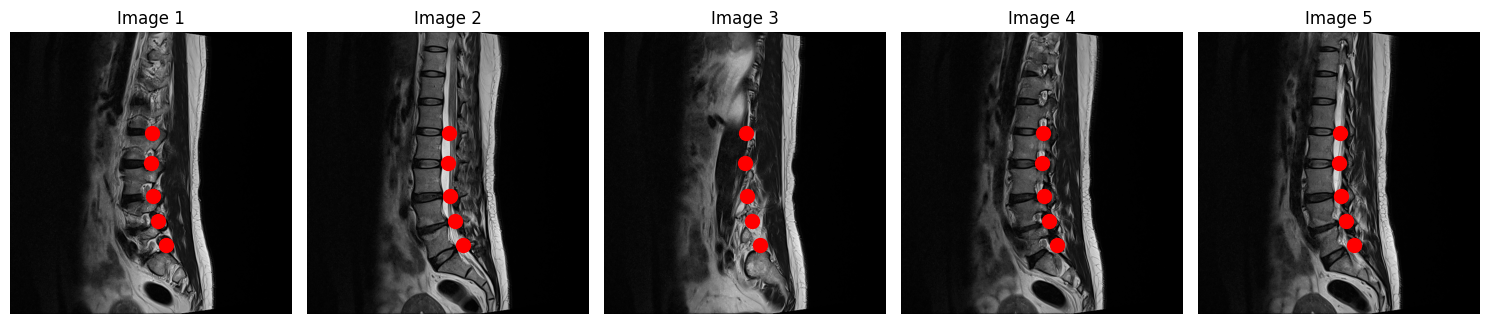

Visualizing Original Testing Images with Markers:


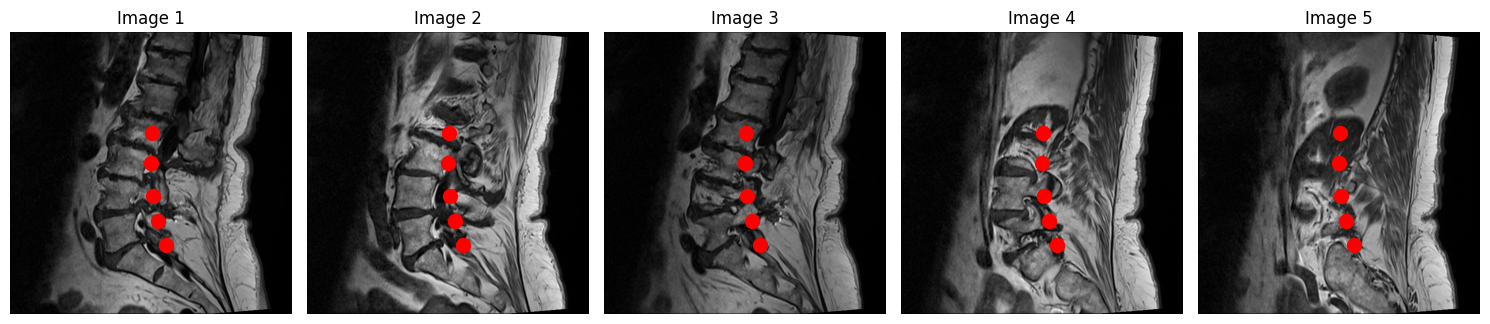

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image

# Function to visualize a set of images with markers
def visualize_images(image_paths, final_df, study_id, series_id, num_images=5):
    plt.figure(figsize=(15, 10))
    
    # Extract marker coordinates for the specified study_id and series_id
    markers = final_df[(final_df['study_id'] == study_id) & (final_df['series_id'] == series_id)]
    
    # Loop through the number of images to display
    for i in range(num_images):
        # Load the DICOM image using SimpleITK
        image = sitk.ReadImage(image_paths[i])
        image_array = sitk.GetArrayFromImage(image)  # Convert to NumPy array
        image_array = np.squeeze(image_array)  # Remove single-dimensional entries
        
        # Convert NumPy array to PIL Image
        pil_image = Image.fromarray(image_array)

        # Plotting the original image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(pil_image, cmap='gray')  # Display as grayscale
        
        # Overlay markers
        if not markers.empty:
            plt.scatter(markers['x'], markers['y'], c='red', s=100, label='Markers', marker='o')
        
        plt.axis('off')  # Hide axis
        plt.title(f'Image {i + 1}')
    
    plt.tight_layout()
    plt.show()

# Example usage
# Visualize original training images with markers for a specific study_id and series_id
study_id = 4003253  # Example study_id
series_id = 702807833  # Example series_id

print("Visualizing Original Training Images with Markers:")
visualize_images(train_image_paths, final_df, study_id, series_id, num_images=5)

# Visualize original testing images (if desired)
print("Visualizing Original Testing Images with Markers:")
visualize_images(test_image_paths, final_df, study_id, series_id, num_images=5)


## Checking for Duplicate Rows in a DataFrame

In data preprocessing, it's important to ensure that there are no duplicate rows in your DataFrame, as duplicates can affect the results of analysis and modeling. This section contains code to identify and count any duplicate rows in the `final_df` DataFrame.

### Steps in the Code:

1. **Identify Duplicates**:
   - Use the `duplicated()` method to find duplicate rows in the DataFrame.

2. **Count Duplicate Rows**:
   - Use the `shape` attribute to determine the number of duplicate rows.

3. **Display Results**:
   - If duplicate rows are found, display them along with the total count. If none are found, a corresponding message will be printed.

### Code Implementation


In [18]:
# Check for duplicate rows
duplicates = final_df[final_df.duplicated()]

# Count the number of duplicate rows
num_duplicates = duplicates.shape[0]

# Display the duplicate rows and count
if num_duplicates > 0:
    print("Duplicate rows found:")
    print(duplicates)
    print(f"\nTotal number of duplicate rows: {num_duplicates}")
else:
    print("No duplicate rows found.")

No duplicate rows found.


## Checking Counts for Each Severity Level

In the context of medical imaging analysis, understanding the distribution of severity levels in the dataset is crucial. This section contains code to count and display the number of instances for each severity level present in the `final_df` DataFrame.

### Steps in the Code:

1. **Count Severity Levels**:
   - Utilize the `value_counts()` method to compute the number of occurrences for each unique value in the `severity` column.

2. **Display Results**:
   - Print the resulting counts to the console for inspection.

### Code Implementation


In [19]:
# Checking the counts for each severity level
severity_counts = final_df['severity'].value_counts()

# Displaying the counts
print("Severity Counts:")
print(severity_counts)


Severity Counts:
severity
normal_mild    37626
moderate        7950
severe          3081
Name: count, dtype: int64


## Computing Class Weights for Severity Levels

In machine learning, class imbalance can lead to models that are biased towards the majority class. To mitigate this issue, we can assign weights to each class during training, making the model pay more attention to the underrepresented classes. This section demonstrates how to compute class weights for the `severity` levels in the `final_df` DataFrame.

### Steps in the Code:

1. **Import Necessary Libraries**:
   - Import `class_weight` from `sklearn.utils` to compute the class weights.

2. **Get Unique Classes**:
   - Identify the unique classes present in the `severity` column of the DataFrame.

3. **Compute Class Weights**:
   - Use the `compute_class_weight` method to calculate the weights for each class, adjusting them inversely to their frequencies.

4. **Create a Class Weight Dictionary**:
   - Map the class labels to their corresponding weights using a dictionary comprehension.

5. **Display Class Weights**:
   - Print the dictionary containing the class labels and their computed weights.

### Code Implementation


In [47]:
from sklearn.utils import class_weight
import numpy as np

# Get the unique classes and their corresponding frequencies
classes = final_df['severity'].unique()
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=classes,
    y=final_df['severity']
)

# Create a dictionary mapping class labels to weights
class_weight_dict = dict(zip(classes, class_weights))

print("Class Weights:", class_weight_dict)


Class Weights: {'normal_mild': 0.4310583107425716, 'moderate': 2.040125786163522, 'severe': 5.264199935086011}


## CustomDataset Class

The `CustomDataset` class is a custom data loader for managing medical imaging datasets, particularly DICOM images. It extends the `Sequence` class from TensorFlow Keras, allowing it to work seamlessly with Keras models during training and evaluation. This class is designed to handle the loading, preprocessing, and augmentation of images efficiently in batches.

### Class Attributes

- **dataframe**: A pandas DataFrame that contains information about the images, including paths and labels.
- **batch_size**: An integer representing the number of samples to be included in each batch.
- **image_size**: A tuple indicating the desired size of the images (width, height) to be resized during loading.
- **transform**: Optional transformations to be applied to images. Can be used for additional data augmentation.
- **normalize**: A boolean flag indicating whether to normalize the image pixel values to the range [0, 1].
- **datagen**: An instance of `ImageDataGenerator` from Keras, used for real-time data augmentation during training.

### Methods

#### `__init__(self, dataframe, batch_size=16, image_size=(256, 256), transform=None, normalize=False, **kwargs)`

The constructor method initializes the `CustomDataset` class with the following parameters:
- `dataframe`: The DataFrame containing image paths and labels.
- `batch_size`: The number of samples per batch (default is 16).
- `image_size`: The target size of images (default is (256, 256)).
- `transform`: Any additional transformations to apply to the images (default is `None`).
- `normalize`: Flag to normalize image data (default is `False`).

#### `__len__(self)`

Returns the number of batches in the dataset, calculated by dividing the total number of samples in the DataFrame by the batch size.

#### `load_image(self, image_path)`

Loads and processes an image from the given file path. The method handles both DICOM and other image formats:
- Reads DICOM files using `pydicom` and extracts the pixel array.
- Loads standard image files using OpenCV (`cv2`).
- Converts the image to a format suitable for model training (uint8) and stacks grayscale images into three channels if necessary.
- Normalizes the image pixel values if the `normalize` flag is set.

#### `__getitem__(self, index)`

This method retrieves a batch of images and their corresponding labels:
- Calculates the start and end indices for the current batch based on the index provided.
- Iterates over the rows of the DataFrame for the current batch to load images and labels.
- Resizes each loaded image to the specified `image_size`.
- Applies any transformations using the `ImageDataGenerator` for real-time augmentation.
- Returns a NumPy array of images and their corresponding labels for the current batch.

### Examwe Usage

To use the `CustomDataset` class, you can initialize it with a DataFrame that contains image paths and labelsages, labels = train_dataset[0]  # Get the first batch


In [48]:
import os
import pydicom
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataset(Sequence):
    def __init__(self, dataframe, batch_size=16, image_size=(256, 256), transform=None, normalize=False, **kwargs):
        super().__init__(**kwargs)  # Call the parent class's constructor
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_size = image_size
        self.normalize = normalize  # Add normalize attribute

        # Set up the ImageDataGenerator for transformations
        self.datagen = ImageDataGenerator(
            horizontal_flip=True,
            rotation_range=15,
            shear_range=15,
            zoom_range=0.1,
            fill_mode='nearest'
        )

        self.transform = transform

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def load_image(self, image_path):
        if image_path.lower().endswith('.dcm'):
            dicom = pydicom.dcmread(image_path, force=True)
            image = dicom.pixel_array
        else:
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if image is None:
                raise FileNotFoundError(f"Could not load image from {image_path}")

        # Convert image to uint8 if necessary
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        # If the image is grayscale, stack it to make 3 channels
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)

        # Normalize the image if the flag is set
        if self.normalize:
            image = image / 255.0  # Normalization to [0, 1]

        return image

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.dataframe))
        batch_df = self.dataframe.iloc[start_idx:end_idx]

        images = []
        labels = []

        for _, row in batch_df.iterrows():
            image_path = row['image_path']
            label = row['severity']  # Assuming label is integer-encoded

            # Load and resize image
            image = self.load_image(image_path)
            image = cv2.resize(image, self.image_size)

            # Apply augmentations (if any)
            if self.transform:
                image = np.expand_dims(image, axis=0)
                image = self.datagen.flow(image, batch_size=1).next()[0]

            images.append(image)
            labels.append(label)

        images = np.array(images)
        labels = np.array(labels)

        return images, labels


## Splitting the Dataset

To evaluate the performance of our machine learning model effectively, we need to separate our dataset into training and validation subsets. This helps ensure that we can train our model on one part of the data while evaluating its performance on an unseen part of the data.

### Code Explanation

- **`train_test_split`**: This function from the `sklearn.model_selection` module is used to split arrays or matrices into random train and test subsets. It provides a simple and efficient way to create training and validation datasets.

- **`final_df`**: This is the DataFrame that contains our entire dataset, which includes the image paths, labels, and any other relevant information.

- **`test_size=0.2`**: This parameter specifies the proportion of the dataset to include in the validation set.

    - **Type**: It can be a float (representing a percentage) or an integer (representing the absolute number of samples).
    - **Value**: Here, we set it to `0.2`, meaning that 20% of the dataset will be allocated for validation, while the remaining 80% will be used for training. This proportion is often chosen to balance model training and validation. A typical range for this parameter is between 0.1 and 0.3, depending on the dataset size.

- **`random_state=42`**: This parameter controls the randomness of the split.

    - **Type**: It can be an integer, which serves as a seed for the random number generator.
    - **Value**: Setting a specific integer value (like `42`) ensures that the split will be reproducible across different runs. This is important for maintaining consistent results during experimentation and debugging. If you do not set this parameter, you will get different splits each time you run the code.

### Resulting DataFrames

- **`train_df`**: This DataFrame contains 80% of the original dataset and will be used to train the machine learning model. It is crucial for the model's learning process.

- **`val_df`**: This DataFrame contains 20% of the original dataset and will be used to validate the performance of the model during training. It helps in assessing how well the model can generalize to unseen data.

### Importance of Splitting

Splitting the dataset into training and validation sets is crucial for:

- **Model Evaluation**: It allows us to assess how well our model generalizes to new, unseen data.

- **Hyperparameter Tuning**: We can use the validation set to fine-tune model parameters without overfitting to the training data.

- **Early Stopping**: Monitoring performance on the validation set can help us implement early stopping, preventing overfitting during the training process.

By ensuring that our model is trained on one subset and validated on another, we improve its reliability and performance when deployed in real-world scenarios.


In [49]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [50]:
train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=42)

## Encoding Severity Labels

In machine learning, especially in classification tasks, it is common to convert categorical labels into numerical values. This process is known as encoding. In this section, we utilize the `LabelEncoder` from the `sklearn.preprocessing` module to transform the severity labels into integers.

### Code Explanation

- **Importing LabelEncoder**: We begin by importing the `LabelEncoder` class, which is specifically designed for encoding categorical labels.

- **Initializing the Label Encoder**: An instance of the `LabelEncoder` is created. This instance will be used to fit the model to our training data and to transform both the training and validation datasets.

- **Fitting and Transforming the Training Set**: The `fit_transform` method is applied to the `train_df['severity']` column. This method:
  
    - Fits the label encoder to the unique severity labels in the training dataset.
    - Transforms these labels into integers, which makes them suitable for training machine learning models.

- **Transforming the Validation Set**: We apply the `transform` method on the `val_df['severity']` column. This method converts the severity labels in the validation set to integers based on the mapping created during the fitting process on the training set.

- **Result**: After this transformation, the severity labels are now represented as integers. You can verify the unique integer labels in the training set by printing them.

### Importance of Label Encoding

Label encoding is crucial because:
- **Machine Learning Compatibility**: Most machine learning algorithms require numerical input, and converting labels into integers ensures compatibility.
- **Model Training**: By encoding labels, we can effectively train classification models to recognize and learn from different severity classes.
- **Preserving Information**: The order of labels can be preserved if required, although in this case, the severity levels are treated as categorical, and the encoding is arbitrary.

By encoding the severity labels into integers, we prepare the data for training our model effectively.


In [51]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on the training set and transform both train and val sets
train_df['severity'] = label_encoder.fit_transform(train_df['severity'])
val_df['severity'] = label_encoder.transform(val_df['severity'])

# Now, your severity labels should be integers
print(train_df['severity'].unique())


[1 0 2]


## Handling Class Imbalance

In classification tasks, it is common to encounter imbalanced datasets, where certain classes have significantly more instances than others. This can lead to biased models that perform poorly on minority classes. In this section, we will address class imbalance by upsampling the minority classes in our dataset.

### Code Explanation

- **Importing the Resample Function**: We begin by importing the `resample` function from the `sklearn.utils` module, which will allow us to create additional samples from the minority cla
    ```

- **Separating Majority and Minority Classes**: The dataset is divided into majority and minority classes based on the severity labels:
    - The **Moderate** class (severity = 1) is treated as the majority class.
    - The **Normal/Mild** class (severity = 0) and **Severe** class (severity = 2) are treated as mino(minority)
    ```

- **Upsampling the Minority Class 'Normal/Mild'**: We use the `resample` function to create additional samples from the minority class:
    - **`replace=True`**: This parameter allows sampling with replacement, meaning that the same instance can be selected multiple times.
    - **`n_samples=len(df_majority_moderate)`**: We specify the number of samples to create, matching the size     random_state=42)
    ```

- **Upsampling the Minority Class 'Severe'**: We apply the same upsampling process              random_state=42)
    ```

- **Combining the Upsampled Classes with the Majority Class**: After upsampling, we concatenate the upsampled minority classes with the majrate, df_minority_severe_upsampled])
    ```

- **Shuffling the Resulting Dataset**: Finally, we shuffle the combined dataset to mix the classes, ensuring that the model doe1, random_state=42).reset_index(drop=True)
    ```

### Importance of Addressing Class Imbalance

Handling class imbalance is crucial because:
- **Improved Model Performance**: Balancing the dataset helps ensure that the model performs well across all classes, particularly the minority ones.
- **Better Generalization**: A well-balanced dataset allows the model to generalize better to unseen data, reducing the risk of overfitting to the majority class.
- **Fair Representation**: Each class's instances contribute to the learning process, ensuring that minority classes are appropriately represented in the final model.

By upsampling the minority classes, we create a more balanced dataset, paving the way for better model training and evaluation.


In [52]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


In [53]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority_moderate = train_df[train_df['severity'] == 1]  # Moderate class (majority)
df_minority_normal = train_df[train_df['severity'] == 0]    # Normal/mild class (minority)
df_minority_severe = train_df[train_df['severity'] == 2]    # Severe class (minority)

# Upsample minority class 'normal/mild'
df_minority_normal_upsampled = resample(df_minority_normal,
                                        replace=True,  # Sample with replacement
                                        n_samples=len(df_majority_moderate),  # Match to majority class size
                                        random_state=42)

# Upsample minority class 'severe'
df_minority_severe_upsampled = resample(df_minority_severe,
                                        replace=True,  # Sample with replacement
                                        n_samples=len(df_majority_moderate),  # Match to majority class size
                                        random_state=42)

# Combine the oversampled classes with the majority class
train_df_resampled = pd.concat([df_minority_normal_upsampled, df_majority_moderate, df_minority_severe_upsampled])

# Shuffle the resulting dataset to mix the classes
train_df_resampled = train_df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

## Creating Train and Validation Datasets

In this section, we will initialize our custom dataset class, `CustomDataset`, to create training and validation datasets for our machine learning model. This allows us to efficiently load and preprocess our images in batches during the training process.

### Code Explanation

- **Initializing the CustomDataset for Training**: We create an instance of the `CustomDataset` class for the training data. Here are the parameters we set:

    - **`dataframe=train_df_resampled`**: This parameter specifies the DataFrame containing the training data, which includes the paths to the images and their corresponding labels.
    
    - **`batch_size=16`**: This parameter sets the number of samples to be loaded in each batch. A batch size of 16 is a common choice, balancing memory efficiency and training speed.

    - **`image_size=(256, 256)`**: This parameter specifies the target size for the images after resizing. Here, we resize all images to a uniform size of 256x256 pixels, ensuring consistency in input dimensions for the model.

    - **`normalize=True`**: This parameter indicates that the images should be normalized during loading. Normalization scales pixel values to a range of [0, 1], which can improve the training efficiency and convergence of the model.

- **Initializing the CustomDataset for Validation**: Similarly, we create an instance of the `CustomDataset` class for the validation data. This dataset will be used to evaluate the model's performance on unseen data during training.

    - **`dataframe=val_df`**: This parameter specifies the DataFrame containing the validation data, which also includes image paths and their corresponding labels.

    - **`batch_size=16`**: Again, we set the batch size to 16 for consistency with the training dataset.

    - **`normalize=True`**: We also normalize the validation images for consistent preprocessing with the training images.

### Importance of Creating Datasets

Creating separate datasets for training and validation is crucial for several reasons:

- **Model Training**: The training dataset is used to teach the model to recognize patterns and make predictions based on the input images.

- **Model Validation**: The validation dataset allows us to assess the model's performance on unseen data. It helps us gauge how well the model generalizes to new instances, which is critical for real-world applications.

By initializing our custom dataset class for both the training and validation datasets, we streamline the data loading and preprocessing process, ensuring that our model receives the input data it needs in an efficient manner.


In [64]:
# Create the train and validation datasets
# Initialize the CustomDataset
train_dataset = CustomDataset(dataframe=train_df_resampled, 
                              batch_size=16, 
                              image_size=(256, 256),
                              normalize=True)

val_dataset = CustomDataset(val_df, batch_size = 16, normalize=True)



## Checking Class Distribution After Resampling

After performing oversampling on our training dataset to address class imbalance, it is crucial to examine the distribution of classes in the dataset. This allows us to verify that the resampling process was successful and that we have balanced our classes adequately.

### Code Explanation

1. **Checking Class Distribution After Resampling**: We calculate the counts of each severity class in the resampled training das)
    ```

    - **`train_df_resampled['severity'].value_counts()`**: This method counts the occurrences of each unique severity label in the resampled training DataFrame. It provides a clear view of how many samples belong to each severity level after the oversampling process.

    - **`print(...)`**: We print the class counts to observe the new distribution of severity levels in the training dataset.

2. **Checking Original Class Distribution Before Resampling**: To understand the impact of our resampling, we also check the distribution of classes in the original 
   lass_counts)
    ```

    - **`train_df['severity'].value_counts()`**: Similar to the previous step, this method counts the occurrences of each unique severity label in the original training DataFrame before any resampling was applied.

    - **`print(...)`**: We print the original class counts for comparison with the resampled class counts.

### Importance of Checking Class Distribution

- **Assessing Balance**: Checking the class distribution before and after resampling allows us to determine whether our oversampling approach was effective in achieving a balanced dataset.

- **Model Training**: A balanced dataset is crucial for training machine learning models as it prevents bias towards the majority class and improves overall model performance.

By comparing the original and new class distributions, we can ensure that our model has a fair representation of all severity levels, which is essential for achieving reliable and accurate predictions.


In [65]:
# Check class distribution after resampling
new_class_counts = train_df_resampled['severity'].value_counts()
print("Class counts after resampling:\n", new_class_counts)

# Check original class distribution before resampling
original_class_counts = train_df['severity'].value_counts()
print("Original class counts before resampling:\n", original_class_counts)

Class counts after resampling:
 severity
2    30070
1    30070
0    30070
Name: count, dtype: int64
Original class counts before resampling:
 severity
1    30070
0     6388
2     2467
Name: count, dtype: int64


## Visualizing Class Distribution Before and After Resampling

To better understand the impact of our resampling process on class distribution, we will create a bar plot comparing the original class counts with the resampled class counts. This visual representation helps us quickly assess whether our efforts to balance the dataset were successful.

### Explanation

1. **Setting Up the Figure**:
   We start by creating a figure to hold our bar plots, ensuring a good aspect ratio for visual clarity.

2. **Creating Bar Plots**:
   We use the Seaborn library to create bar plots for both the original and resampled class counts. The x-axis displays the class labels (severity levels), while the y-axis represents the count of samples in each class. 

   - The first bar plot shows the original class counts, using a distinct color to differentiate it from the resampled counts.
   - The second bar plot represents the resampled class counts, which should ideally match the count of the majority class after resampling.

3. **Adding Title and Labels**:
   A title and axis labels are added to the plot for clarity. The title indicates what the plot represents, while the x-axis label specifies the classes and the y-axis label indicates the counts.

4. **Including Legend and Adjusting X-Ticks**:
   A legend is included to differentiate between the original and resampled distributions. The x-tick labels are set to horizontal for better readability.

5. **Displaying the Plot**:
   Finally, we render the plot to visualize the class distributions.

### Importance of Visualizing Class Distribution

- **Clear Comparison**: The bar plot provides a clear visual comparison of the class distribution before and after resampling.
  
- **Effectiveness of Resampling**: By visually assessing the plot, we can quickly determine if our resampling technique has effectively balanced the classes in our training dataset.

This visualization is a powerful tool for understanding how preprocessing steps like resampling can impact model training and performance.


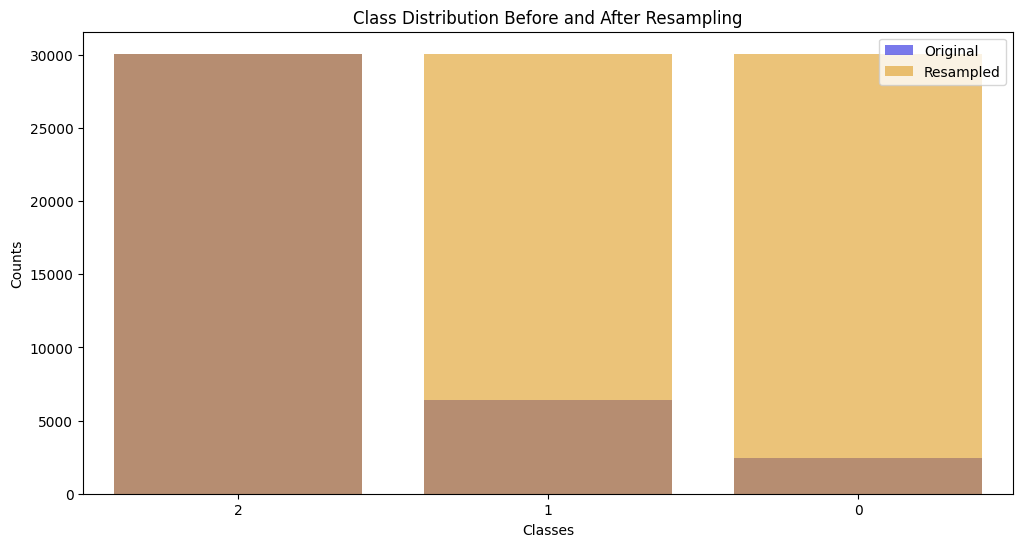

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the figure for bar plots
plt.figure(figsize=(12, 6))
sns.barplot(x=original_class_counts.index.astype(str), y=original_class_counts.values, color='blue', alpha=0.6, label='Original')
sns.barplot(x=new_class_counts.index.astype(str), y = new_class_counts.values, color='orange', alpha=0.6, label='Resampled')

plt.title('Class Distribution Before and After Resampling')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.legend()
plt.xticks(rotation=0)
plt.show()


## Building a Convolutional Neural Network (CNN) for Image Classification

In this section, we create a Convolutional Neural Network (CNN) using TensorFlow and Keras for the task of image classification. The model is designed to classify images into three different severity levels based on the features extracted from DICOM images.

### Model Architecture Overview

1. **Sequential Model**:
   - We use the `Sequential` model from Keras, which allows us to build the neural network layer by layer in a linear stack.

2. **Input Layer**:
   - The input shape is defined to accommodate images of size **256x256 pixels** with **3 color channels** (RGB). This means that the model expects input images to be in this format.

3. **Convolutional Blocks**:
   - The model consists of **four convolutional blocks**. Each block includes:
     - **Convolutional Layers**: We use `Conv2D` to apply convolutional operations on the input images. The filters, kernel size, and activation functions are defined as follows:
       - **Filters**: The number of filters used in each convolutional layer increases with depth (32, 64, 128, 256). This helps the model learn more complex features at higher levels.
       - **Kernel Size**: A kernel size of **(3, 3)** is used for all convolutional layers, which is a common choice for image processing tasks.
       - **Padding**: We use `padding='same'` to ensure that the spatial dimensions of the output are the same as the input.
       - **Activation Function**: The ReLU (Rectified Linear Unit) activation function is applied to introduce non-linearity into the model.
     - **Batch Normalization**: After each convolutional layer, `BatchNormalization` is applied to normalize the output of the previous layer. This helps stabilize and speed up the training process.
     - **Max Pooling**: `MaxPooling2D` is used with a pool size of **(2, 2)** to reduce the spatial dimensions of the feature maps, effectively downsampling the data and retaining only the most important features.
     - **Dropout**: `Dropout` layers are introduced with varying rates (0.2, 0.3, 0.4, 0.5) to prevent overfitting by randomly setting a fraction of the input units to 0 during training. This encourages the model to learn more robust features.

4. **Flatten Layer**:
   - After the convolutional blocks, the output is flattened into a 1D array to connect it to the fully connected layers. This is done using the `Flatten` layer.

5. **Fully Connected Layers**:
   - A `Dense` layer with **128 units** and ReLU activation is added as a fully connected layer. This layer learns combinations of the features extracted by the convolutional layers.
   - Another `Dropout` layer with a rate of **0.5** is added to further reduce overfitting.

6. **Output Layer**:
   - The final `Dense` layer has **3 units** (one for each severity class) with a **softmax activation function**. This function outputs a probability distribution over the classes, allowing us to classify the input images into one of the three categories.

### Model Compilation

- The model is compiled using the **Adam optimizer** with a learning rate of **0.0001**. Adam is a popular optimization algorithm that adapts the learning rate during training.
- The loss function used is **sparse categorical crossentropy**, which is suitable for multi-class classification problems where the target variable is represented as integers.
- The model will track **accuracy** as a metric during training and evaluation.

### Model Summary

- Finally, we call `model.summary()` to display the architecture of the model, including the number of parameters at each layer and the overall structure.

### Conclusion

This CNN architecture is designed to effectively learn features from medical imaging data and classify them into specified severity levels. The combination of convolutional layers, pooling layers, and dropout regularization aims to create a robust model that generalizes well to unseen data.


In [67]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
# Create your model
model = Sequential()

# Adjusted Input layer to accommodate 256x256 images
model.add(Input(shape=(256, 256, 3)))

# First Convolutional Block
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second Convolutional Block
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Block
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fourth Convolutional Block
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for multi-class classification
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile the model with categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,565,219 (36.49 MB)

 Trainable params: 9,563,299 (36.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Callbacks for Training the Model

Callbacks are functions that can be applied at specific stages of the training process to improve the model's performance and manage the training workflow effectively. In this section, we implement three important callbacks: **Learning Rate Scheduler**, **Early Stopping**, and **Model Checkpoint**.

### 1. Learning Rate Reduction Callback

The `ReduceLROnPlateau` callback is designed to reduce the learning rate when a metric has stopped improving. This can help the model converge more effectively when it reaches a plateau in learning.

- **Parameters**:
  - `monitor`: This specifies which metric to monitor. In this case, we are monitoring the validation loss (`'val_loss'`).
  - `factor`: The factor by which the learning rate will be reduced. Here, it is set to **0.5**, meaning the learning rate will be halved.
  - `patience`: This parameter determines how many epochs to wait for improvement before reducing the learning rate. Here, we set it to **2** epochs. If the validation loss does not improve for two consecutive epochs, the learning rate will be reduced.
  - `min_lr`: The minimum learning rate value. This is set to **1e-6**, which ensures that the learning rate does not fall below this threshold.
  - `verbose`: If set to **1**, it enables logging of messages when the learning rate is reduced.

### 2. Early Stopping Callback

The `EarlyStopping` callback is used to stop the training process once the model performance stops improving on the validation dataset, helping to prevent overfitting.

- **Parameters**:
  - `monitor`: Similar to the learning rate reduction, we monitor the validation loss (`'val_loss'`).
  - `patience`: This indicates how many epochs to wait for an improvement in the monitored metric before stopping the training. Here, it is set to **3** epochs.
  - `restore_best_weights`: When set to **True**, it restores the model weights from the epoch with the best validation loss, ensuring that the model used after training is the best one.

### 3. Model Checkpoint Callback

The `ModelCheckpoint` callback saves the model at specified intervals, ensuring that the best version of the model is retained.

- **Parameters**:
  - `filepath`: The path where the model will be saved. In this case, it is set to `'best_model.keras'`.
  - `monitor`: Again, we monitor the validation loss (`'val_loss'`).
  - `save_best_only`: When set to **True**, it ensures that only the model with the best validation loss is saved during training, preventing unnecessary storage of model weights.

### Conclusion

Implementing these callbacks will help in effectively managing the training process, allowing for better optimization and generalization of the model. By adjusting the learning rate dynamically, stopping early when the model performance plateaus, and saving the best model, we aim to enhance the overall performance and reliability of the trained model.


In [69]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [70]:
# learning rate reduction callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          
    patience=2,           
    min_lr=1e-6,          
    verbose=1             
)
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True)




## Training the Model

In this section, we initiate the training of our deep learning model using the `fit` method. This process involves fitting the model to the training data while validating its performance on a separate validation dataset. Below are the key components of the training process:

### Model Fitting

The `model.fit()` method is used to train the model on the training dataset. It takes several important parameters:

- **`train_dataset`**: This is the training dataset created using the `CustomDataset` class, which loads and preprocesses the training images and their corresponding labels in batches.

- **`validation_data`**: This parameter is set to `val_dataset`, which is the validation dataset also created using the `CustomDataset` class. It allows us to evaluate the model's performance on unseen data after each epoch.

- **`epochs`**: The number of epochs specifies how many complete passes through the training dataset the model will perform. In this case, we set it to **20 epochs**. This means the model will iterate over the training data 20 times, adjusting weights based on the error at each step.

- **`callbacks`**: This parameter includes a list of callbacks that are executed at certain points during training:
  - `early_stopping`: This callback will monitor the validation loss and stop training if it does not improve for a specified number of epochs, helping to prevent overfitting.
  - `model_checkpoint`: This callback saves the model weights after each epoch if there is an improvement in validation loss, ensuring that we keep the best version of the model.
  - `lr_scheduler`: This callback dynamically reduces the learning rate when the validation loss stops improving, which can help the model converge more effectively.

- **`verbose`**: This parameter controls the level of output during training. A value of **1** means that progress messages will be printed for each epoch, providing insight into the training process.

### Conclusion

By executing the `fit` method with the specified parameters, we train our model on the training data while simultaneously evaluating its performance on the validation data. The combination of callbacks ensures that the training process is efficient and effective, ultimately improving the model's performance on unseen data. 


In [71]:

history = model.fit(
        train_dataset,
        validation_data = val_dataset,
        epochs=20,
        callbacks=[early_stopping, model_checkpoint, lr_scheduler],
        verbose=1
    )

Epoch 1/20
5639/5639 ━━━━━━━━━━━━━━━━━━━━ 1742s 306ms/step - accuracy: 0.3593 - loss: 1.2267 - val_accuracy: 0.6419 - val_loss: 1.1463 - learning_rate: 1.0000e-04
Epoch 2/20
5639/5639 ━━━━━━━━━━━━━━━━━━━━ 1737s 308ms/step - accuracy: 0.4028 - loss: 1.1296 - val_accuracy: 0.7698 - val_loss: 0.9176 - learning_rate: 1.0000e-04
Epoch 3/20
5639/5639 ━━━━━━━━━━━━━━━━━━━━ 1716s 304ms/step - accuracy: 0.4628 - loss: 1.0481 - val_accuracy: 0.6502 - val_loss: 0.8287 - learning_rate: 1.0000e-04
Epoch 4/20
5639/5639 ━━━━━━━━━━━━━━━━━━━━ 1702s 302ms/step - accuracy: 0.5179 - loss: 0.9695 - val_accuracy: 0.5819 - val_loss: 0.8643 - learning_rate: 1.0000e-04
Epoch 5/20
5639/5639 ━━━━━━━━━━━━━━━━━━━━ 1717s 304ms/step - accuracy: 0.5588 - loss: 0.8984 - val_accuracy: 0.6067 - val_loss: 0.8116 - learning_rate: 1.0000e-04
Epoch 6/20
5639/5639 ━━━━━━━━━━━━━━━━━━━━ 1723s 305ms/step - accuracy: 0.6008 - loss: 0.8365 - val_accuracy: 0.5591 - val_loss: 0.8552 - learning_rate: 1.0000e-04
Epoch 7/20
5639/5639 ━

## Visualizing Model Performance

In this section, we visualize the training and validation performance of the model over the epochs. Visualizations help us understand how well our model is learning and whether it's overfitting or underfitting. Below are the key components of the visualization process:

### 1. Importing Necessary Libraries
We use the following libraries to create our visualizations:
- **Nython.
- **MatplPython.
- **Sraphics.
- **sklearn.ereports.

### 2. Plotting Training & Validation Loss and Accuracy

#### a. Creating Subplots
- We use `plt.subplot()` to create a grid of plots. In this case, we set up a 1x2 grid for displaying loss and accuracy side by side.

#### b. Plotting Loss
- In the first subplot, we plot the training and validation loss:
  - **Training Loss**: This line shows how the loss decreases as the model learns from the training data.
  - **Validation Loss**: This line indicates how well the model performs on the validation dataset.
- We add titles and labels to the axes for clarity.

#### c. Plotting Accuracy
- In the second subplot, we plot the training and validation accuracy:
  - **Training Accuracy**: This line represents the accuracy of the model on the training dataset.
  - **Validation Accuracy**: This line indicates the accuracy of the model on the validation dataset.
- We again include titles and labels for the axes.

### 3. Displaying the Plots
- `plt.tight_layout()` is used to adjust the padding between and around subplots for a cleaner look.
- Finally, `plt.show()` renders the plots on the screen.

### Conclusion
By visualizing the training and validation loss and accuracy over epochs, we can assess the model's performance, check for signs of overfitting or underfitting, and make informed decisions about further model tuning and training strategies.


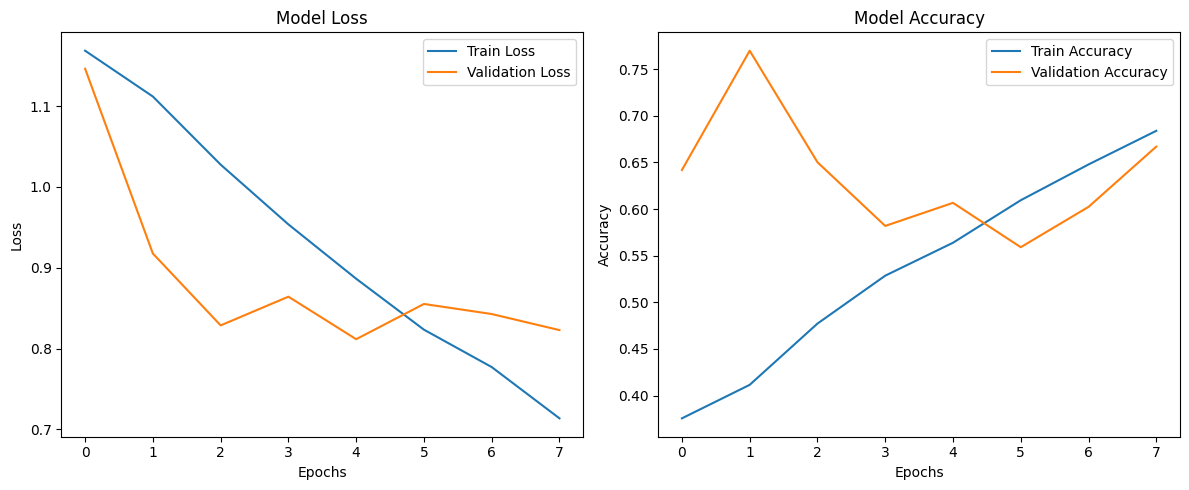

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plotting training & validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



## Loading the Best Model

In this section, we load the best-performing model that was saved during the training process. This allows us to make predictions or further evaluate the model without needing to retrain it from scratch. Below are the key components of this process:

###  Importing the Required Function
- We import the `load_model` function from the `tensorflow.keras.models` module. This function enables us to load a model that was previously saved to disk.

###  Loading the Best Model
- We used the `load_model` function to load the model from the specified file:


In [73]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
model = load_model('best_model.keras')


## Collecting True Labels and Generating Predictions

In this section, we will retrieve the true labels from the validation dataset and generate predictions using our trained model. This is a critical step in evaluating the model's performance.

### 1. Collecting True Labels
- **Purpose**: To gather the actual severity labels from the validation DataFrame, which will be used for comparison with the predicted labels.
- **Method**: We extract the `severity` column from the `val_df` DataFrame and convert it into a NumPy array. This format is convenient for further analysis and performance evaluation.

### 2. Generating Predictions
- **Purpose**: To obtain predictions from the trained model for the validation dataset.
- **Method**: We use the `predict` method of our model to generate predictions based on the validation dataset. This function outputs a NumPy array of predicted probabilities for each class.

### 3. Extracting Predicted Class Labels
- **Purpose**: To convert the predicted probabilities into class labels, which represent the predicted severity levels for each sample.
- **Method**: We utilize the `np.argmax` function, which identifies the index of the maximum probability across the class dimension. This index corresponds to the predicted class label for each sample.

### Summary
- This process involves first collecting the true labels from the validation set, which serve as the ground truth for model evaluation.
- Next, we generate predictions using our trained model and convert the resulting probabilities into class labels. This allows us to assess the model's accuracy and effectiveness in classifying unseen data.


In [76]:
# Collect true labels from the validation DataFrame
true_labels = val_df['severity'].values  # Get true labels as a NumPy array

# Get predictions from the model
predictions = model.predict(val_dataset)  # Replace with your validation data loader
predicted_labels = np.argmax(predictions, axis=1)  # Get the predicted class indices




609/609 ━━━━━━━━━━━━━━━━━━━━ 276s 453ms/step


## Generating and Visualizing the Confusion Matrix

The confusion matrix is a powerful tool for assessing the performance of a classification model. It provides insight into how well the model's predictions align with the actual labels. In this section, we will generate and visualize the confusion matrix for our trained model.

### 1. Collecting True Labels
To evaluate our model's performance, we first need the true labels of the validation dataset. This step involves extracting the `severity` column from the validation DataFrame (`val_df`). The true labels serve as a reference for comparing against the model's predictions.

### 2. Generating the Confusion Matrix
The confusion matrix itself is generated using the `confusion_matrix` function from the `sklearn.metrics` module. This function takes two arguments: the true labels and the predicted labels obtained from the model. The resulting confusion matrix summarizes how many instances were correctly classified for each class versus how many were misclassified.

### 3. Visualizing the Confusion Matrix
To make the confusion matrix more interpretable, we visualize it using a heatmap. This visualization highlights the relationship between the true labels and the predicted labels:

- **Heatmap Representation**: Each cell in the heatmap indicates the number of predictions for a given class, allowing us to see at a glance where the model is performing well and where it is struggling.
- **Annotations**: The heatmap includes numerical annotations that display the counts directly within the cells, making it easy to assess model performance quantitatively.
- **Color Mapping**: The heatmap uses a color gradient (typically shades of blue) to represent the number of instances in each category, with darker shades indicating higher counts.

### 4. Saving the Visualization
Finally, the confusion matrix plot is saved as an image file for future reference. This is useful for documentation or sharing results with stakeholders.

### Conclusion
The confusion matrix not only shows the overall accuracy of the model but also reveals specific strengths and weaknesses in the classification process. By analyzing the confusion matrix, we can identify which classes are frequently misclassified and make informed decisions for further improvements to the model.


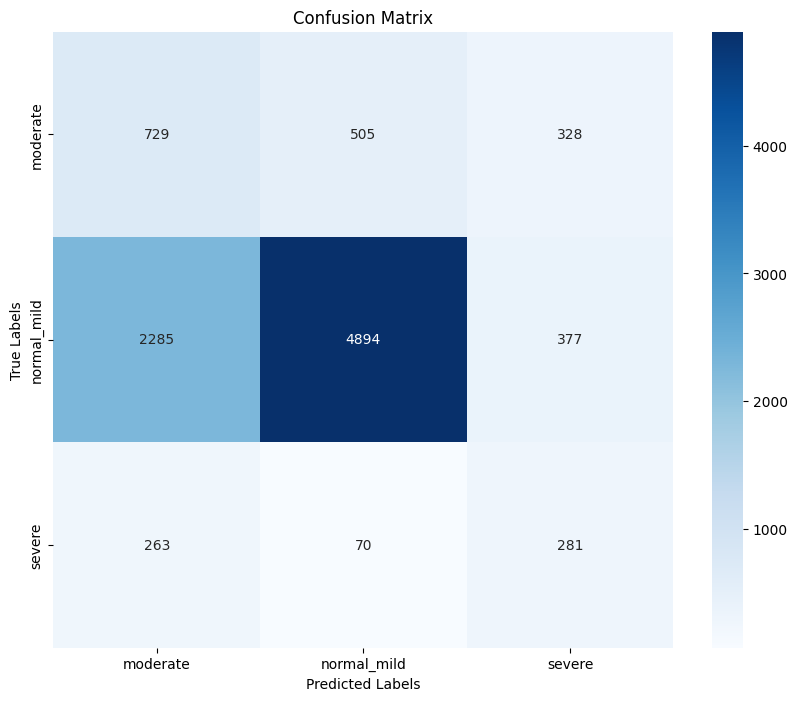

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Collect true labels from the validation DataFrame
true_labels = val_df['severity'].values  # Get true labels as a NumPy array

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot = True, fmt ='d', cmap ='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("Confusion Matrix.png")
plt.show()



## Insights from the Confusion Matrix

### Overview
The confusion matrix provides valuable insights into the performance of our classification model across three severity classes: **moderate**, **normal_mild**, and **severe**. Below are the key insights derived from the confusion matrix data.

### 1. True Positives (TP)
- **Moderate**: 729 instances were correctly classified as **moderate**.
- **Normal_Mild**: 4894 instances were correctly classified as **normal_mild**.
- **Severe**: 281 instances were correctly classified as **severe**.
- The model shows a relatively high number of correct predictions, especially for the **normal_mild** class.

### 2. False Positives (FP)
- **Moderate**:
  - 505 instances of **normal_mild** were incorrectly predicted as **moderate**.
  - 328 instances of **severe** were incorrectly predicted as **moderate**.
- **Normal_Mild**:
  - 2285 instances of **moderate** were incorrectly predicted as **normal_mild**.
  - 377 instances of **severe** were incorrectly predicted as **normal_mild**.
- **Severe**:
  - 263 instances of **moderate** were incorrectly predicted as **severe**.
  - 70 instances of **normal_mild** were incorrectly predicted as **severe**.
- The **normal_mild** class causes confusion with both **moderate** and **severe** classes, indicating potential misclassification risks.

### 3. False Negatives (FN)
- **Moderate**: 833 instances were misclassified (505 as **normal_mild** and 328 as **severe**).
- **Normal_Mild**: 2662 instances were misclassified (2285 as **moderate** and 377 as **severe**).
- **Severe**: 333 instances were misclassified (263 as **moderate** and 70 as **normal_mild**).
- The **normal_mild** class exhibits a significant number of false negatives, suggesting that the model may struggle to accurately identify mild cases.

### 4. Class Imbalance Impact
- The **normal_mild** class has the highest number of true instances (4894) compared to the other classes, potentially aiding the model's ability to learn features for this class.
- The **severe** class shows reasonable correct predictions, but also notable confusion with other classes.

### 5. Overall Accuracy
- The model performance, while showing high true positive counts, is impacted by false positives and false negatives, indicating a need for further tuning or rebalancing, lead to improved classification accuracy.


-------

## Generating the Classification Report

The classification report provides a detailed evaluation of the model's performance on the validation dataset. It summarizes key metrics for each class, such as precision, recall, F1-score, and support.

### Explanation of Metrics

- **True Labels**: These are the actual severity labels from the validation dataset, representing the ground truth for our predictions.

- **Predicted Labels**: These are the severity labels predicted by the model during inference based on the validation dataset.

- **Target Names**: The class names corresponding to the numeric labels, which are used for better readability in the report.

### Key Metrics Explained

1. **Precision**: This metric indicates the accuracy of the positive predictions. It is the ratio of correctly predicted positive observations to the total predicted positives. High precision means that fewer irrelevant instances are included in the predicted positive class.

2. **Recall**: Also known as sensitivity or true positive rate, recall measures how effectively the model identifies positive instances. It is the ratio of correctly predicted positive observations to all actual positives. A high recall indicates that the model successfully captures most of the positive instances.

3. **F1-Score**: This is the harmonic mean of precision and recall, providing a single score that balances both metrics. The F1-score is particularly useful when dealing with imbalanced classes, as it gives a better measure of the model's performance in scenarios where precision and recall are critical.

4. **Support**: This refers to the number of actual occurrences of each class in the validation dataset. It provides context for interpreting the precision and recall values.

### Importance of the Classification Report

The classification report is essential for evaluating how well the model performs across different severity classes. It helps in identifying:

- **Strengths and Weaknesses**: By analyzing the precision and recall for each class, we can determine where the model excels and where it may need improvements.

- **Class Imbalances**: The report can reveal which classes are underperforming, allowing for targeted strategies to enhance the model, such as data augmentation or collecting more samples for those classes.

- **Informed Decisions**: Insights from the classification report can guide future adjustments to the model, including changes in hyperparameters, model architecture, or data preprocessing methods.

In summary, the classification report serves as a comprehensive evaluation tool that allows us to understand our model's performance and make informed decisions for further enhancements.


In [78]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names = label_encoder.classes_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    moderate       0.22      0.47      0.30      1562
 normal_mild       0.89      0.65      0.75      7556
      severe       0.28      0.46      0.35       614

    accuracy                           0.61      9732
   macro avg       0.47      0.52      0.47      9732
weighted avg       0.75      0.61      0.65      9732



## Insights from the Classification Reportce

The classification report summarizes the performance of the model across three severity classes: **moderate**, **normal_mild**, and **severe**. Below are insights based on the precision, recall, and F1-score for each class:

### Class-wise Analysis

1. **Moderate Class:**
   - **Precision**: 0.22
     - This low precision indicates that when the model predicts the "moderate" class, it is correct only 22% of the time. Many of its predictions for this class are incorrect, suggesting that the model is likely misclassifying instances as either "normal_mild" or "severe".
   - **Recall**: 0.47
     - The recall of 47% suggests that the model identifies 47% of the actual "moderate" cases correctly. However, nearly half of the actual "moderate" cases are missed.
   - **F1-Score**: 0.30
     - This score reflects a poor balance between precision and recall, highlighting significant challenges in classifying this category accurately.
   - **Support**: 1562
     - There are 1562 instances of the "moderate" class in the validation dataset, indicating a substantial representation.

2. **Normal Mild Class:**
   - **Precision**: 0.89
     - A high precision indicates that the model is very accurate when it predicts the "normal_mild" class, meaning only a small fraction of predictions are incorrect.
   - **Recall**: 0.65
     - The model correctly identifies 65% of the actual "normal_mild" cases, suggesting that some of these instances are being misclassified as "moderate" or "severe".
   - **F1-Score**: 0.75
     - The F1-score of 0.75 indicates a good balance between precision and recall for this class, suggesting that the model performs well overall in classifying "normal_mild".
   - **Support**: 7556
     - This class has a significant presence in the dataset, making up a large portion of the instances.

3. **Severe Class:**
   - **Precision**: 0.28
     - This low precision means that only 28% of the predicted "severe" cases are correct. Many predictions in this class are likely false positives, suggesting confusion with the other classes.
   - **Recall**: 0.46
     - A recall of 46% shows that the model captures fewer than half of the actual "severe" cases, indicating a substantial number of missed detections.
   - **F1-Score**: 0.35
     - The F1-score reflects an overall inadequate classification ability for the "severe" class, similar to the "moderate" class.
   - **Support**: 614
     - There are relatively fewer instances of the "severe" class, which may contribute to the model's challenges in learning its characteristics effectively.

### Overall Model Performance
- **Accuracy**: 0.61
  - The model's overall accuracy of 61% suggests that it correctly classifies 61% of the instances in the validation set. While this accuracy is reasonable, there are significant discrepancies in performance across different classes.
  
- **Macro Average**:
  - **Precision**: 0.47
  - **Recall**: 0.52
  - **F1-Score**: 0.47
  - The macro average indicates the model's overall performance across all classes without considering class imbalance. The relatively low averages suggest that improvements are needed in classifying the less represented classes (moderate and severe).

- **Weighted Average**:
  - **Precision**: 0.75
  - **Recall**: 0.61
  - **F1-Score**: 0.65
  - The weighted averages account for the number of instances in each class, showing that the model performs better overall hts into model performance, especially in imbalanced scenarios.


----

## Model Saving Explanation

At the conclusion of the training process, it is essential to save the trained model for future use. This allows for making predictions, further training, or evaluation without the need to retrain the model from scratch.

### Code Overview

The provided code snippet outlines how to save the trained Convolutional Neural Network (CNN) model in two specific locations:

1. **Local Saving**: 
   - The model is saved to the current working directory with the filename `CNN_LSDC_model.keras`. This includes the entire model architecture, trained weights, optimizer settings, and the training configuration.
   - Saving the model in this manner is useful for local development and testing environments, as it provides a straightforward way to store the model file.

2. **Kaggle Environment Saving**: 
   - The same model is saved explicitly in the Kaggle working directory (`/kaggle/working/`). This is particularly important when working within the Kaggle platform, as it ensures that the model file can be accessed after executing the notebook.
   - Keeping the filename consistent across both saving locations (`CNN_LSDC_model.keras`) aids in clarity and organization.

3. **Confirmation Message**:
   - A print statement confirms the successful saving of the model. This feedback is crucial for the user, indicating that the model file is now securely stored and can be found in the specified directory.

### Importance of Saving the Model

- **Future Inference**: Saving the trained model allows for easy loading later on for making predictions, which significantly saves time and computational resources compared to retraining the model.
  
- **Further Training**: Should there be a need to continue training the model with additional data or adjustments, having the model saved ensures that the process can be resumed without any loss of progress.

- **Reproducibility**: Saving the model promotes reproducibility in research and development. It allows others to share, reuse, and verify the exact model architecture and weights.

In summary, this code segment effectively captures and secures the model's state at the end of training, facilitating easy retrieval and application in future tasks.


In [79]:
# Save the full model at the end of training
model.save('CNN_LSDC_model.keras')
# Save the full model in the current Kaggle working directory
model.save('/kaggle/working/CNN_LSDC_model.keras')
print( "full model saved in output as CNN_LSDC_model.keras")

full model saved in output as CNN_LSDC_model.keras


# Project Summary: Image Classification with Convolutional Neural Networks (CNN)

## Overview
In this project, we developed a Convolutional Neural Network (CNN) to classify medical images into three categories: normal/mild, moderate, and severe. The dataset comprised images with varying levels of severity, and the objective was to build a robust model capable of accurately predicting the severity level based on visual features.

## Key Steps in the Project

1. **Data Preparation**:
   - Loaded and explored the dataset.
   - Analyzed the distribution of severity levels, which revealed an imbalance in the dataset.
   - Performed data augmentation and normalization to enhance the model's ability to generalize.

2. **Data Splitting**:
   - Split the dataset into training and validation sets (80% training, 20% validation) to ensure that the model can learn from a subset of the data while being evaluated on unseen data.

3. **Label Encoding**:
   - Converted categorical severity labels into integer values using `LabelEncoder`, preparing the data for the model.

4. **Handling Class Imbalance**:
   - Implemented resampling techniques to balance the dataset. Oversampled the minority classes (normal/mild and severe) to match the majority class (moderate) in order to mitigate bias in the model.

5. **Model Development**:
   - Constructed a CNN architecture consisting of multiple convolutional layers, pooling layers, dropout layers, and a final dense layer for classification.
   - Utilized regularization techniques such as L2 regularization and dropout to prevent overfitting.

6. **Training the Model**:
   - Compiled the model with the Adam optimizer and categorical cross-entropy loss function.
   - Employed callbacks such as early stopping, model checkpointing, and learning rate reduction to optimize training efficiency and performance.

7. **Model Evaluation**:
   - Monitored training and validation loss and accuracy throughout the training process.
   - Loaded the best-performing model based on validation loss for further evaluation.
   - Predicted labels for the validation set and generated a confusion matrix and classification report to assess model performance.

8. **Results**:
   - Analyzed the confusion matrix and classification report, revealing insights into precision, recall, and F1 scores for each class.

9. **Model Saving**:
   - Saved the trained model for future inference and further training.

## Summary of Findings
- The model achieved an overall accuracy of approximately 61% on the validation set.
- Precision and recall varied among the classes, with the normal/mild class performing significantly better than the moderate and severe classes.
- Class imbalance affected the performance, as the model struggled to predict the minority classes accurately.

## Further Recommendations
1. **Data Collection**:
   - Consider acquiring more data, especially for the minority classes, to improve the model's ability to generalize.

2. **Advanced Techniques**:
   - Explore advanced architectures such as ResNet, DenseNet, or EfficientNet, which may yield better performance due to their deeper layers and residual connections.
   - Investigate transfer learning by utilizing pre-trained models on large image datasets to leverage learned features.

3. **Hyperparameter Tuning**:
   - Conduct hyperparameter optimization using techniques like grid search or randomized search to identify the best model parameters.

4. **Ensemble Methods**:
   - Experiment with ensemble techniques by combining predictions from multiple models to enhance classification accuracy.

5. **Deployment**:
   - Explore deploying the model using web frameworks (e.g., Flask, Django) or cloud platforms to make the model accessible for real-time predictions.

6. **User Feedback**:
   - Implement mechanisms to gather user feedback on predictions, which can help in continuous learning and model improvement.

By following these recommendations, we can further enhance the model's performance and reliability, making it a more effective tool for classifying image severity in medical applications.


------